ML-Driven Test Case Prioritization Prototype

Using Random Forest Algorithm
to prioritize regression test cases and visualize results.

Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

Read Excel Data

In [2]:
# -----------------------------
# Step 1: Read Historical Test Cases Execution Data
# -----------------------------

# Path to  Excel file
excel_file =excel_file = "data/dummy_test_cases.xlsx"

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Display first few rows
print("Data read from Excel:\n", df.head())

# Simulated label
df["Label"] = ((df["FailureRate"]*0.6 + (df["LinesChanged"]/100)*0.3 + (df["RecentFails"]/5)*0.1) > 0.5).astype(int)


Data read from Excel:
   TestCase  FailureRate  LinesChanged  ExecTime  RecentFails
0     TC_1     0.112540            65         7            2
1     TC_2     0.618440            11         7            3
2     TC_3     0.782224            85         8            0
3     TC_4     0.860461            12         8            4
4     TC_5     0.371125            37         3            1


Feature Engineering

In [3]:
# -----------------------------
# Step 2: Prepare Features
# -----------------------------
X = df[["FailureRate", "LinesChanged", "ExecTime", "RecentFails"]]
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Training Models

In [4]:
# -----------------------------
# Step 3: Train Models
# -----------------------------
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_probs = rf.predict_proba(X)[:, 1]  # Probability for prioritization

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_probs = lr.predict_proba(X)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X)[:, 1]

# Add probabilities to DataFrame for prioritization
df["RF_Prob"] = rf_probs
df["LR_Prob"] = lr_probs
df["XGB_Prob"] = xgb_probs

# Sort test cases by Random Forest probability
prioritized_tests = df.sort_values(by="RF_Prob", ascending=False)

Evaluating Models

In [5]:
# -----------------------------
# Step 4: Evaluate Models
# -----------------------------
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

results = [
    evaluate_model("Random Forest", y_test, y_pred_rf),
    evaluate_model("Logistic Regression", y_test, y_pred_lr),
    evaluate_model("XGBoost", y_test, y_pred_xgb)
]

results_df = pd.DataFrame(results)
print("Model Comparison:\n")
print(results_df)


Model Comparison:

                 Model  Accuracy  Precision  Recall  F1-Score
0        Random Forest  0.833333   0.500000     1.0  0.666667
1  Logistic Regression  0.666667   0.333333     1.0  0.500000
2              XGBoost  0.833333   0.500000     1.0  0.666667


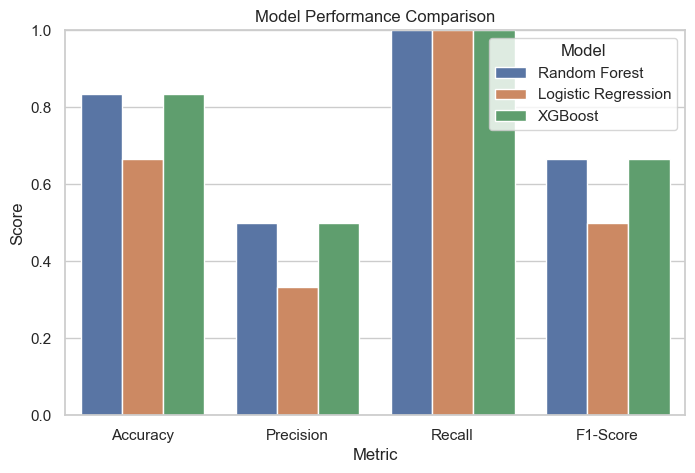

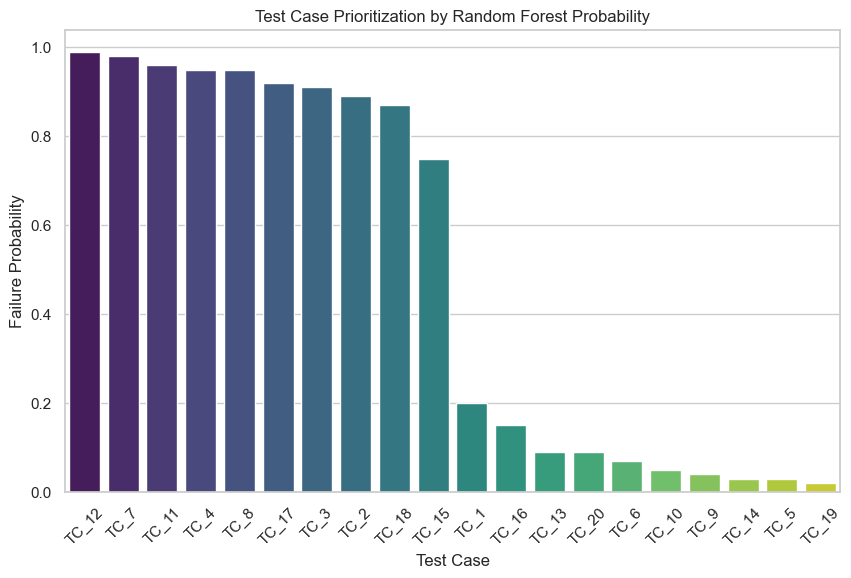

In [6]:
# -----------------------------
# Step 6: Visualization
# -----------------------------
sns.set(style="whitegrid")

# Plot 1: Model Performance Comparison
plt.figure(figsize=(8, 5))
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(x="Metric", y="Score", hue="Model", data=results_melted)
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

# Plot 2: Test Case Prioritization (Random Forest Probabilities)
plt.figure(figsize=(10, 6))
sns.barplot(x="TestCase", y="RF_Prob", hue="TestCase",
            data=prioritized_tests, palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.title("Test Case Prioritization by Random Forest Probability")
plt.ylabel("Failure Probability")
plt.xlabel("Test Case")
plt.show()